## 必要包导入

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.fftpack as sf
import scipy.constants as sc

## 参数定义

In [122]:
# Parameters
R_ref = 20e+3         # reference range
Vr = 150              # platform velocity
Tr = 2.5e-6              # range time duration
Kr = 40e+12            # range chirp rate
f0 = 5.3e+09            # carrier frequency

Fr = 120e+6              # range sampling frequency
Fa = 100               # azimuth sampling frequency
theta_sqc = 5*np.pi/180 # squint angle

Ta = 2.56               # azimuth time duration

La = 3.316                 # antenna length

Vs = Vr*1.0            # platform speed over ground
Vg = Vr*1.0            # ground speed
theta_rc = np.arcsin(np.sin(theta_sqc)*Vr/Vg) # real squint angle
f_etac = 2*Vs*np.sin(theta_sqc)*f0/sc.c # Doppler center frequency
theta_bw = 0.886*sc.c/f0/La # beamwidth
Naz = Ta*Fa # azimuth samples
Nrg = Tr*Fr # range samples

delta_fdop = 2*Vs*np.cos(theta_rc)/sc.c*f0*theta_bw # Doppler bandwidth



N_az = int(2*Naz) 
# N_rg = int(2*Nrg)
N_rg = 3072
Tr_total = N_rg/Fr

eta = np.linspace(-Ta, Ta - 1/Fa, N_az) 
tau = np.linspace(-Tr_total/2, Tr_total/2 - 1/Fr, N_rg)  
eta = eta.reshape(N_az,1)
tau = tau.reshape(1,N_rg)

# eta_array = eta + eta_c
print(N_az,N_rg,f_etac,theta_rc*180/np.pi,delta_fdop)

512 3072 462.24522088803343 5.0 79.85179455753497


## 点目标定义

### 回波信号函数

In [123]:
range_pixel = sc.c/Fr/2
R_0 = R_ref + np.array([-600*range_pixel,-300*range_pixel,0*range_pixel,300*range_pixel,600*range_pixel])     #零多普勒面斜距
# R_0 = R_ref + np.array([0])
R_etac_center = R_ref/np.cos(theta_rc)
eta_c_center = -R_ref*np.tan(theta_rc)/Vr
eta_c = eta_c_center + np.array([-30/Fa,-10/Fa,0,10/Fa,30/Fa])        #实际图像波束中心时间
# eta_c = eta_c_center + np.array([10/Fa])
R_etac = R_0/np.cos(theta_rc)
eta_array = eta + eta_c_center
print('R_etac:',R_etac,'\n','eta_c:',eta_c)

def generate_echo_signal_corrected():
    """
    修正的回波信号生成
    """
    # 使用统一的参考斜距
    R_ref_unified = R_etac_center  # 或者使用 R_ref，但要一致
    
    S_2d = np.zeros((N_az, N_rg), dtype=complex)

    print('generate_echo_signal_corrected running...')
    for i in range(len(R_0)):
        # 斜距历史
        R_eta = np.sqrt(R_0[i]**2 + (Vr*(eta_array+eta_c[i]-eta_c_center))**2)
        
        # 统一的距离徙动校正参考
        R_migration_ref = R_etac_center  # 使用统一的参考
        
        # 距离窗 - 使用统一的参考
        rectan_rg = (np.abs(tau - 2*(R_eta - R_migration_ref)/sc.c) <= Tr/2)
        
        # 方位向天线方向图
        ant_pattern = np.sinc(0.886*np.arctan(Vr*(eta_array - eta_c[i])/R_0[i])/theta_bw)**2
        
        # 距离向调频 - 使用统一的参考
        range_chirp = np.exp(1j*np.pi*Kr*(tau - 2*(R_eta - R_migration_ref)/sc.c)**2)
        
        # 载波相位
        carrier_phase = np.exp(-1j*4*np.pi*R_eta*f0/sc.c)

        S_2d += rectan_rg * ant_pattern * carrier_phase * range_chirp
    
    return S_2d

S_2d = generate_echo_signal_corrected()


R_etac: [19324.05270965 19700.22473026 20076.39675087 20452.56877147
 20828.74079208] 
 eta_c: [-11.96515514 -11.76515514 -11.66515514 -11.56515514 -11.36515514]
generate_echo_signal_corrected running...


### 点目标参数验证

In [124]:
def validate_system_parameters():
    """
    验证所有系统参数
    """
    print("=== 系统参数验证 ===")
    
    # 重新计算所有关键参数
    lambda0 = sc.c / f0
    
    # 1. 多普勒参数
    f_etac_recalc = 2 * Vs * np.sin(theta_sqc) * f0 / sc.c
    print(f"多普勒中心频率:{f_etac_recalc:.2f} Hz")
    
    # 2. 波束宽度
    theta_bw_recalc = 0.886 * lambda0 / La
    print(f"波束宽度:{theta_bw_recalc:.4f} rad")
    
    # 3. 多普勒带宽
    delta_fdop_recalc = 2 * Vs * np.cos(theta_rc) / lambda0 * theta_bw_recalc
    print(f"多普勒带宽:{delta_fdop_recalc:.2f} Hz")
    
    # 4. 检查采样率是否足够
    if Fa < 1.2 * delta_fdop_recalc:
        print(f"警告: 方位采样率 {Fa:.0f} Hz 可能不足，需要 > {2*delta_fdop_recalc:.0f} Hz")
    
    # 5. 检查距离徙动参考
    R_etac_center_recalc = R_ref / np.cos(theta_rc)
    print(f"距离徙动参考斜距:{R_etac_center_recalc:.2f} m")

    TBP = Fa * Ta
    print(f"时间带宽积 (TBP): {TBP:.2f}")
    
    return f_etac_recalc, theta_bw_recalc, delta_fdop_recalc, R_etac_center_recalc

f_etac_new, theta_bw_new, delta_fdop_new, R_etac_center_new = validate_system_parameters()

=== 系统参数验证 ===
多普勒中心频率:462.25 Hz
波束宽度:0.0151 rad
多普勒带宽:79.85 Hz
距离徙动参考斜距:20076.40 m
时间带宽积 (TBP): 256.00


### 点目标示意图

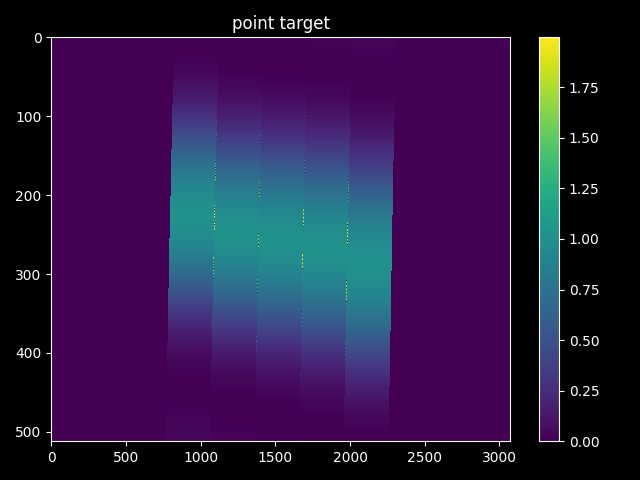

In [125]:
plt.figure()
plt.pcolormesh(np.abs(S_2d))
bottom,top = plt.ylim()
plt.ylim(top,bottom)
plt.title('point target')
plt.colorbar()
plt.tight_layout()
plt.show()

## 坐标轴定义

f_rg: (1, 3072) f_azi: (512, 1) range_pixel: 1.2491352416666666


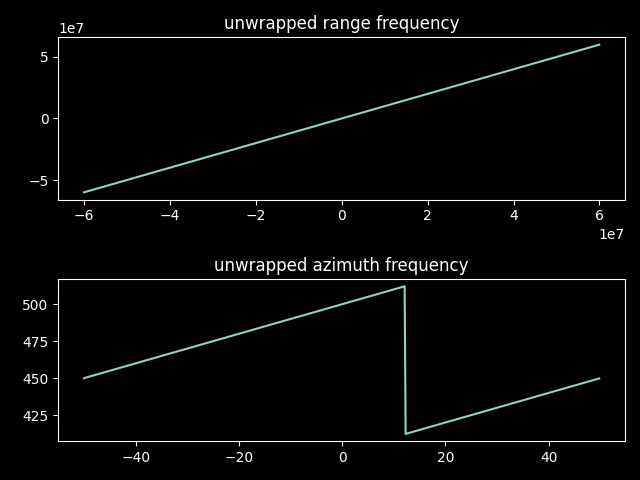

In [126]:
N_azimuth_fft = N_az
N_range_fft = N_rg
f_rg = np.fft.fftshift(np.linspace(-Fr/2, Fr/2 - Fr/N_range_fft, N_range_fft))
f_rg -= np.round((f_rg - 0) / Fr) * Fr
f_azi = np.fft.fftshift(np.linspace(-Fa/2, Fa/2 - Fa/N_azimuth_fft, N_azimuth_fft))
f_azi += np.round((-f_azi+f_etac)/Fa)*Fa


f_rg = f_rg.reshape(1,N_range_fft)
f_azi = f_azi.reshape(N_azimuth_fft, 1)
print('f_rg:', f_rg.shape, 'f_azi:', f_azi.shape, 'range_pixel:', range_pixel)
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.linspace(-Fr/2, Fr/2 - Fr/N_range_fft, N_range_fft),np.fft.fftshift(f_rg[0,:]))
plt.title('unwrapped range frequency')
plt.subplot(2,1,2)
plt.plot(np.linspace(-Fa/2, Fa/2 - Fa/N_azimuth_fft, N_azimuth_fft),np.fft.fftshift(f_azi[:,0]))
plt.title('unwrapped azimuth frequency')
plt.tight_layout()
plt.show()

## 参考函数相乘
%参考函数会引入线性相位，这部分也需要补偿%

%在f_tau=0,f_eta=f_etac处展开参考函数%

0.0965575649660967


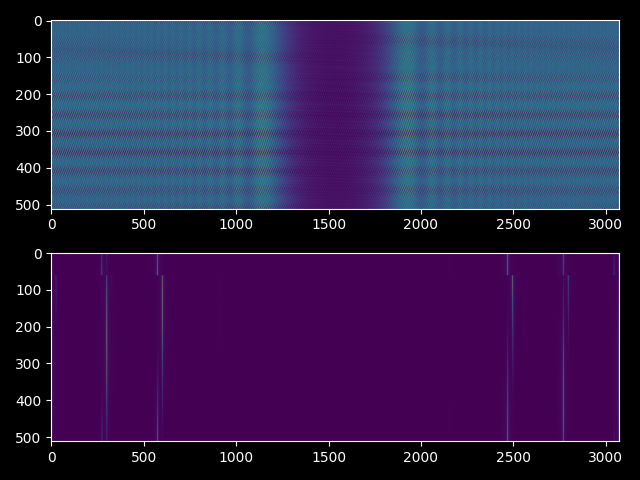

1166.5155136789865 16072.236280900928


In [127]:
# Reference Range to focus --- R_theta_ref
from os import abort


R_theta_ref = R_ref

# reference function
if (sc.c*np.max(np.abs(f_azi))/2/Vr/f0)**2 > 1/2:
    abort("Too large azimuth dopler frequency, invalid for Stolt interpolation.")
print(sc.c*np.max(np.abs(f_azi))/2/Vr/f0)
D = np.sqrt(1- (sc.c*f_etac/2/Vr/f0)**2)

H_theta_ref = np.exp(1j*4*np.pi*(R_theta_ref)/sc.c*np.sqrt((f0+f_rg)**2 - (sc.c*(f_azi)/2/Vr)**2) + 1j*np.pi*f_rg**2/Kr)
# # H_azi_offset
H_az_offset = 1
H_az_offset *= np.exp(-1j*2*np.pi*(f_azi*Ta))
H_az_offset *= np.exp(1j*2*np.pi*(sc.c*R_theta_ref*f_etac/2/D/f0/Vr**2)*f_azi)
# # H_rg_offset
H_rg_offset = 1
H_rg_offset *= np.exp(1j*2*np.pi*(f_rg*Tr_total/2))
H_rg_offset = H_rg_offset*np.exp(-1j*2*np.pi*(2*R_theta_ref/sc.c/D)*f_rg)

S_2df = sf.fft2(S_2d)

S_2df_theta_ref = S_2df*H_theta_ref*H_az_offset*H_rg_offset

S_rdf_theta_ref = sf.ifft(S_2df_theta_ref,axis=1)
# S_rdf_theta_ref = np.fft.fftshift(S_rdf_theta_ref,axes=1)

range_compression_position = np.argmax(np.abs(S_rdf_theta_ref[0,:]))


plt.figure()
plt.subplot(2,1,1)
plt.imshow(np.abs(S_2df_theta_ref),aspect='auto')


plt.subplot(2,1,2)
plt.imshow(np.abs(S_rdf_theta_ref),aspect='auto')

plt.tight_layout()
plt.show()

print((sc.c*R_theta_ref*f_etac/2/D/f0/Vr**2)*Fa, (2*R_theta_ref/sc.c/D)*Fr)

## 插值核定义

窗函数能量：0.5877
中心插值核能量：1.0000
中心插值核峰值：1.0000


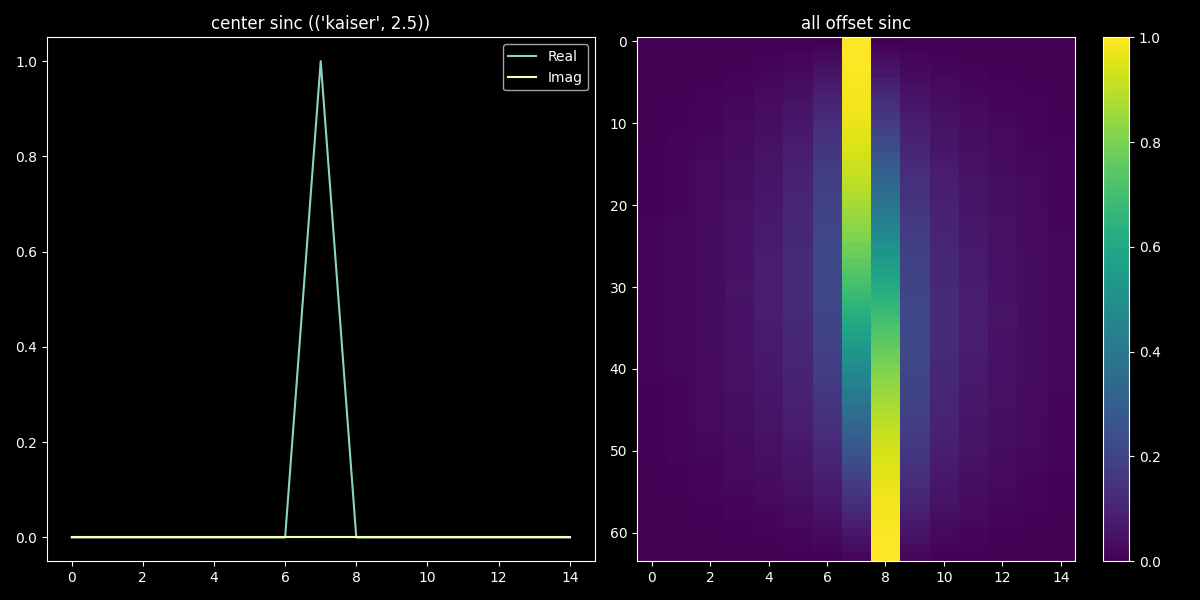

In [128]:
interp_num = 15
interp_step = 64
N_pad = 64

# 1. 生成插值网格
interp_pos = np.linspace(0, 1-1/interp_step, interp_step)
interp_ind = np.arange(np.floor((1-interp_num)/2), np.floor((interp_num+1)/2))
interp_xvalue = interp_ind.reshape(1, interp_num) - interp_pos.reshape(interp_step, 1)

# 2. 生成基础sinc核（不应用任何缩放）
base_sinc = np.sinc(interp_xvalue)

# 3. 优化窗函数选择（提升能量）
# window_type = 'hann'  # 改用Hann窗（能量更高）
window_type = ('kaiser', 2.5)  # 或使用更小β的Kaiser窗
window = ss.get_window(window_type, interp_num).reshape(1, interp_num)

# 4. 计算窗函数归一化因子
window_energy = np.sum(window**2)/interp_num
print(f"窗函数能量：{window_energy:.4f}")

# 5. 应用窗函数
windowed_sinc = base_sinc * window

# 6. 核能量归一化（保持整体能量守恒）
# 计算理想插值核能量（中心位置应为1）
target_energy = 1.0
current_energy = np.sum(windowed_sinc**2,axis=1)
energy_scale = np.sqrt(target_energy / current_energy)

# 7. 应用能量缩放
interp_sinc = windowed_sinc * energy_scale[:,None]

# 8. 验证最终插值核
center_kernel = interp_sinc[0, :]
print(f"中心插值核能量：{np.sum(center_kernel**2):.4f}")
print(f"中心插值核峰值：{np.max(np.abs(center_kernel)):.4f}")

# 9. 可视化
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(center_kernel.real, label='Real')
plt.plot(center_kernel.imag, label='Imag')
plt.title(f'center sinc ({window_type})')
plt.legend()

plt.subplot(122)
plt.imshow(np.abs(interp_sinc), aspect='auto', cmap='viridis')
plt.title('all offset sinc')
plt.colorbar()
plt.tight_layout()
plt.show()


## stolt插值计算

### 相关函数定义


#### stolt插值函数

In [129]:
# ...existing code...
def stolt_interpolation_fast_fixed(Delta_f_stolt, S_2df_theta_ref, interp_sinc, N_pad, etac_index=None):
    """
    高效、矢量化的 Stolt 插值（修正版）
    Delta_f_stolt: (N_azi, N_rg) 偏移（以采样点为单位，可以为负）
    S_2df_theta_ref: (N_azi, N_rg) 原始二维频域（未 fftshift 或 已按原逻辑传入则函数内部做 fftshift）
    interp_sinc: (interp_step, interp_num) 插值核
    N_pad: 每侧填充列数
    返回：插值后的 (N_azi, N_rg) 矩阵（与输入 Delta_f_stolt 形状相同）
    """
    interp_step, interp_num = interp_sinc.shape
    half_interp = interp_num // 2

    # shift + 两侧各填充 N_pad 列
    N_azi, N_rg = S_2df_theta_ref.shape
    pad_total = 2 * N_pad
    total_cols = N_rg + pad_total
    S_pad = np.zeros((N_azi, total_cols), dtype=S_2df_theta_ref.dtype)
    S_pad[:, N_pad:N_pad + N_rg] = S_2df_theta_ref

    # points / fractional part (以样点为单位)
    points_all = np.floor(Delta_f_stolt).astype(int)           # 整数偏移
    frac_part = Delta_f_stolt - points_all                     # 小数部分 [0,1)
    frac_idx = np.round(frac_part * interp_step).astype(int)   # 映射到 interp_step 个子位置
    frac_idx = np.clip(frac_idx, 0, interp_step - 1)           # 保证范围

    # 目标索引的基址：对于每个列 j，目标中心索引为 N_pad + j + points_all[row,j]
    j_indices = np.arange(N_rg)[None, :]                       # shape (1, N_rg)
    center_indices = N_pad + j_indices + points_all            # shape (N_azi, N_rg)
    # 左侧第一个采样（window 起点）
    left_indices = center_indices - half_interp                # shape (N_azi, N_rg)

    # 构造窗口索引矩阵，范围 length = interp_num
    # idx_matrix shape -> (N_azi, N_rg, interp_num)
    offsets = np.arange(interp_num)[None, None, :]             # (1,1,interp_num)
    idx_matrix = left_indices[:, :, None] + offsets            # 广播相加

    # 有效掩码并 clamp 索引以避免越界（越界点后面用原始值替代）
    valid_mask_per_sample = (idx_matrix >= 0) & (idx_matrix < total_cols)  # (N_azi,N_rg,interp_num)
    idx_matrix_clamped = np.where(valid_mask_per_sample, idx_matrix, 0)     # 越界位置设为 0（临时）

    # 提取窗口数据：从 S_pad expand 到 (N_azi,1,total_cols) 再按 idx_matrix_clamped 取值
    S_pad_exp = S_pad[:, None, :]   # shape (N_azi,1,total_cols)
    window_data = np.take_along_axis(S_pad_exp, idx_matrix_clamped, axis=2)  # -> (N_azi,N_rg,interp_num)

    # 取出对应的插值核：interp_sinc[frac_idx] -> shape (N_azi, N_rg, interp_num)
    interp_kernel = interp_sinc[frac_idx]  # advanced indexing 得到所需形状

    # 逐元素相乘并沿窗口轴求和
    S_out = np.sum(window_data * interp_kernel, axis=2)  # (N_azi, N_rg)
    
    # 对于任何窗口有越界的点，用原始（未插值 shift 后）值替代（最近邻退化处理）
    invalid_any = ~np.all(valid_mask_per_sample, axis=2)  # (N_azi, N_rg)
    if np.any(invalid_any):
        S_out[invalid_any] = S_2df_theta_ref[invalid_any]

    # 调试与能量分析（保持原接口）
    if etac_index is not None:
        stolt_debug_analysis(S_2df_theta_ref, S_out, Delta_f_stolt, etac_index)
    stolt_energy_analysis(S_2df_theta_ref, S_out)

    return S_out
# ...existing code...

def stolt_debug_analysis(original, interpolated, shifts, etac_index):
    """
    Stolt插值调试分析
    """
    N_azi, N_rg = original.shape
    center_rg = N_rg // 2
    
    print("=== Stolt插值详细分析 ===")
    
    # 分析多普勒中心附近的点
    debug_range = range(max(0, etac_index - 3), min(N_azi, etac_index + 4))
    
    for i in debug_range:
        orig_val = original[i, center_rg]
        interp_val = interpolated[i, center_rg]
        shift_val = shifts[i, center_rg]
        
        phase_diff = np.angle(interp_val) - np.angle(orig_val)
        amp_ratio = np.abs(interp_val) / (np.abs(orig_val) + 1e-12)
        
        print(f"行{i:3d}: 偏移={shift_val:6.2f}, 相位差={phase_diff:7.4f}, 幅度比={amp_ratio:6.4f}, "
              f"原始幅度={np.abs(orig_val):.4f}, 插值幅度={np.abs(interp_val):.4f}")

def stolt_energy_analysis(original, interpolated):
    """
    能量分析
    """
    E_before = np.sum(np.abs(original)**2)
    E_after = np.sum(np.abs(interpolated)**2)
    energy_change = 100 * (E_after / E_before - 1)
    
    print(f"能量变化: {energy_change:+.4f}%")
    
    if abs(energy_change) > 1:
        print("警告: 能量变化过大!")

#### 效果测试

=== Stolt插值 ===
能量变化: +3.7916%
警告: 能量变化过大!


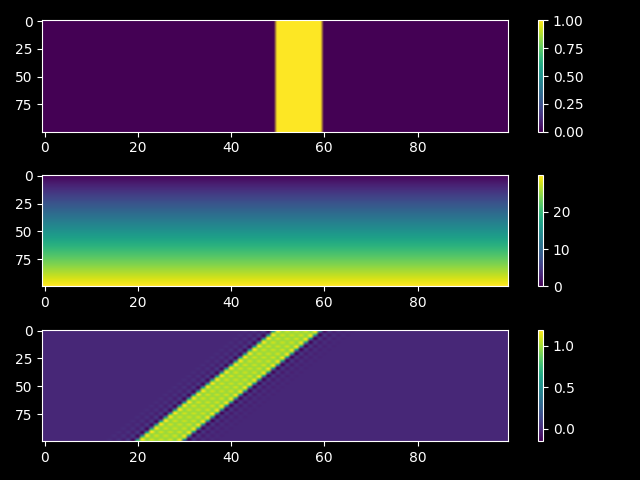

In [130]:
def test_stolt_interpolation_comprehensive():
    """
    Stolt插值
    """
    print("=== Stolt插值 ===")

    # 测试
    test_Data = np.zeros([100,100])
    test_Data[:,50:60] = 1
    offset = np.zeros_like(test_Data)
    # offset = 20*np.ones_like(test_Data)
    for i in range(offset.shape[0]):
        offset[i,:] = i/3.33
    result_data =  stolt_interpolation_fast_fixed(offset,test_Data,interp_sinc,0)
    plt.figure()
    plt.subplot(3,1,1)
    plt.imshow(test_Data,aspect='auto')
    plt.colorbar()
    plt.subplot(3,1,2)
    plt.imshow(offset,aspect='auto')
    plt.colorbar()
    plt.subplot(3,1,3)
    plt.imshow(result_data,aspect='auto')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    return 

# 运行全面测试
test_passed = test_stolt_interpolation_comprehensive()


### a preview of stolt interpolation

最优基准行索引: 319, 多普勒中心索引: 319


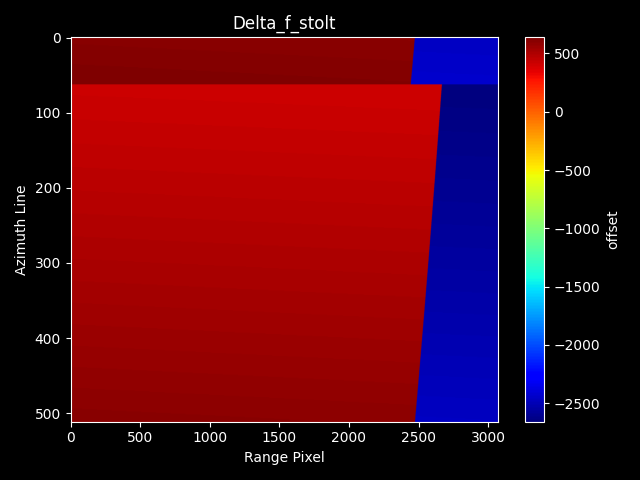

In [ ]:

etac_index = np.argmin(np.abs(f_azi - f_etac))
f_rg_shift = np.fft.fftshift(f_rg,axes=1)                 
# f_stolt = np.sqrt((f0+f_rg_shift)**2-(sc.c*f_azi/(2*Vr))**2) - f0
f_stolt_azi = np.sqrt((f0+0)**2-(sc.c*f_azi/(2*Vr))**2) - f0
best_ref_index = etac_index
print(f"最优基准行索引: {best_ref_index}, 多普勒中心索引: {etac_index}")

### useless code ###
# f_stolt_ref = f_stolt[best_ref_index,:]
# factor = 0.00
# max_fre_stolt = np.max(f_stolt_ref)
# min_fre_stolt = np.min(f_stolt_ref)
# diff = max_fre_stolt - min_fre_stolt
# max_fre_stolt += factor*diff
# min_fre_stolt -= factor*diff
# f_stolt_ref_uniform = np.linspace(min_fre_stolt, max_fre_stolt, N_range_fft)
# f_stolt_ref_uniform = f_rg_shift[0,:]
# f_stolt_ref_uniform = f_stolt_azi + f_rg_shift[0,:]
### useless code ###

# view 1
# 实际进行离散傅里叶变换时，总是认为频率轴的范围是(-f_r,f_r)
# stolt变换后的频率轴为(-f_r+f_stolt_c(f_eta),f_r+f_stolt_c(f_eta))，所以有一个额外的处理
# view 2
# 有一个已经处在stolt变换后的正交频率轴(f'_tau,f_eta)的信号
# 信号的频谱范围为(-f_r+f_stolt_c:f_r+f_stolt_c,-f_a+f_etac:f_a+f_etac)
# 但在处理时没有迁移到基带，因此在两个频率轴上会发生缠绕
# 坐标轴定义里对方位向的缠绕进行了处理，使每行的频率与真实的方位向频率对应
# 这里也要对距离向的缠绕进行处理，使每列的频率与真实的方位向正交距离向频率(f'_tau)对应
f_stolt_ref_uniform = np.round((-f_rg_shift[0,:]+f_stolt_azi)/Fr)*Fr + f_rg_shift[0,:]
f_rg_src = np.sqrt((f_stolt_ref_uniform+f0)**2+(sc.c*f_azi/(2*Vr))**2) - f0


Delta_f_stolt = (f_rg_src - f_rg_shift)/ (Fr/(N_range_fft))
plt.figure()
plt.imshow(Delta_f_stolt, aspect='auto', cmap='jet')
plt.colorbar(label='offset')
plt.title('Delta_f_stolt')
plt.xlabel('Range Pixel')
plt.ylabel('Azimuth Line')
plt.tight_layout()
plt.show()

### start stolt interpolation

In [132]:
S_2df_theta_ref_shift = np.fft.fftshift(S_2df_theta_ref,axes=1)
S_2df_theta_ref_2_shift = stolt_interpolation_fast_fixed(Delta_f_stolt, S_2df_theta_ref_shift, interp_sinc, N_pad,etac_index)


=== Stolt插值详细分析 ===
行316: 偏移=513.18, 相位差=-2.5890, 幅度比=2.0721, 原始幅度=141.7917, 插值幅度=293.8057
行317: 偏移=513.61, 相位差=-3.5053, 幅度比=0.9883, 原始幅度=207.6824, 插值幅度=205.2474
行318: 偏移=514.04, 相位差=-2.8992, 幅度比=0.9409, 原始幅度=343.1977, 插值幅度=322.9162
行319: 偏移=514.48, 相位差=-3.5112, 幅度比=0.5679, 原始幅度=345.0255, 插值幅度=195.9433
行320: 偏移=514.91, 相位差= 0.3851, 幅度比=1.7657, 原始幅度=229.5922, 插值幅度=405.3923
行321: 偏移=515.35, 相位差=-0.0815, 幅度比=0.4892, 原始幅度=626.7895, 插值幅度=306.6102
行322: 偏移=515.78, 相位差=-0.0974, 幅度比=0.4617, 原始幅度=872.5911, 插值幅度=402.9074
能量变化: +3.9118%
警告: 能量变化过大!


### 插值前后二位频域相位对比

fetac_ind 319
3.0376305285983474
-0.47356088115128037


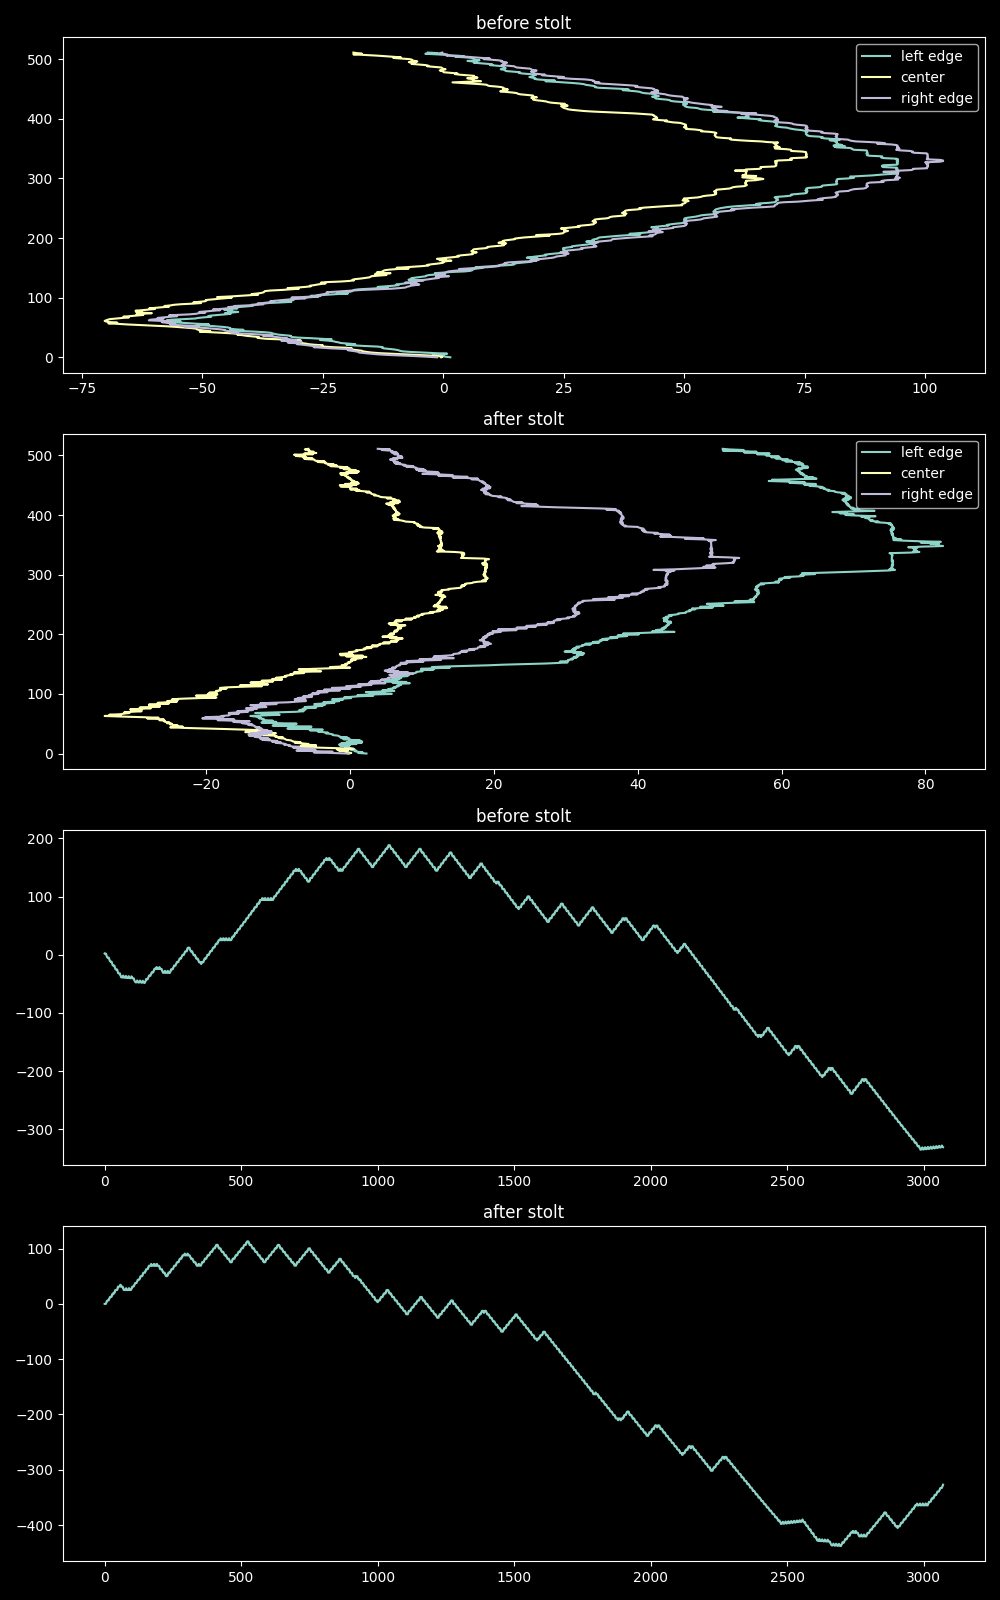

In [133]:
S_2df_theta_ref_shift = np.fft.fftshift(S_2df_theta_ref,axes=1)
print('fetac_ind',etac_index)
print(np.angle(S_2df_theta_ref_shift[etac_index,int(N_range_fft/2)]))
print(np.angle(S_2df_theta_ref_2_shift[etac_index,int(N_range_fft/2)]))

plt.figure(figsize=(10,16))
plt.subplot(4,1,1)
plt.plot(np.unwrap(np.angle((S_2df_theta_ref_shift)[:,int(N_range_fft/2)-100])),range(N_azimuth_fft),'-',label='left edge')
plt.plot(np.unwrap(np.angle((S_2df_theta_ref_shift)[:,int(N_range_fft/2)])),range(N_azimuth_fft),'-',label='center')
plt.plot(np.unwrap(np.angle((S_2df_theta_ref_shift)[:,int(N_range_fft/2)+100])),range(N_azimuth_fft),'-',label='right edge')
plt.legend()
plt.title('before stolt')


plt.subplot(4,1,2)
plt.plot(np.unwrap(np.angle((S_2df_theta_ref_2_shift)[:,int(N_range_fft/2)-100])),range(N_azimuth_fft),'-',label='left edge')
plt.plot(np.unwrap(np.angle((S_2df_theta_ref_2_shift)[:,int(N_range_fft/2)])),range(N_azimuth_fft),'-',label='center')
plt.plot(np.unwrap(np.angle((S_2df_theta_ref_2_shift)[:,int(N_range_fft/2)+100])),range(N_azimuth_fft),'-',label='right edge')
plt.legend()
plt.title('after stolt')


plt.subplot(4,1,3)
plt.plot(range(N_range_fft),np.unwrap(np.angle(S_2df_theta_ref_shift[etac_index,:])),'-')
plt.title('before stolt')

plt.subplot(4,1,4)
plt.plot(range(N_range_fft),np.unwrap(np.angle(S_2df_theta_ref_2_shift[etac_index,:])),'-')
plt.title('after stolt')
plt.tight_layout()
plt.show()

### 插值前后距离多普勒域对比

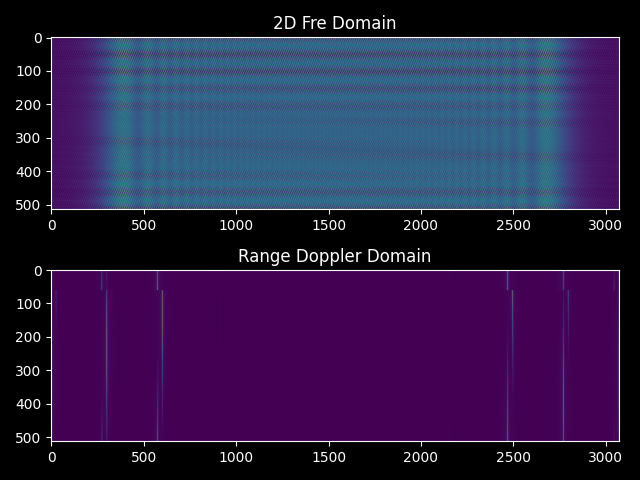

C:\Users\28699\AppData\Local\Temp\ipykernel_34148\3012979608.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


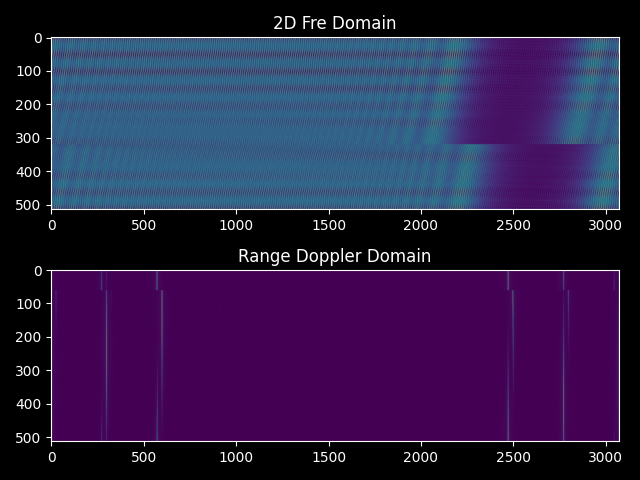

In [134]:
S_2df_theta_ref_2 = np.fft.fftshift(S_2df_theta_ref_2_shift,axes=1)
S_rdf_theta_ref_2 = sf.ifft(S_2df_theta_ref_2_shift,axis=1)

plt.figure()
plt.subplot(2,1,1)
plt.imshow(np.fft.fftshift(np.abs(S_2df_theta_ref)),aspect='auto')
# plt.xlim(0,256)
# plt.ylim(0,256)
plt.title('2D Fre Domain')

plt.subplot(2,1,2)
plt.imshow(np.abs(S_rdf_theta_ref),aspect='auto')
# plt.xlim(400,1600)
plt.title('Range Doppler Domain')


plt.tight_layout()
plt.show()

plt.figure()
plt.subplot(2,1,1)
plt.imshow(np.fft.fftshift(np.abs(S_2df_theta_ref_2)),aspect='auto')
plt.title('2D Fre Domain')
# plt.xlim(0,256)
# plt.ylim(0,256)


plt.subplot(2,1,2)

plt.imshow(np.abs(S_rdf_theta_ref_2),aspect='auto')
# plt.xlim(400,1600)
plt.title('Range Doppler Domain')



plt.tight_layout()
plt.show()


### 插值前后点目标对比

max position and value after stolt:
0 0 188.55182713092887
max position and value before stolt:
0 0 183.94423426913147


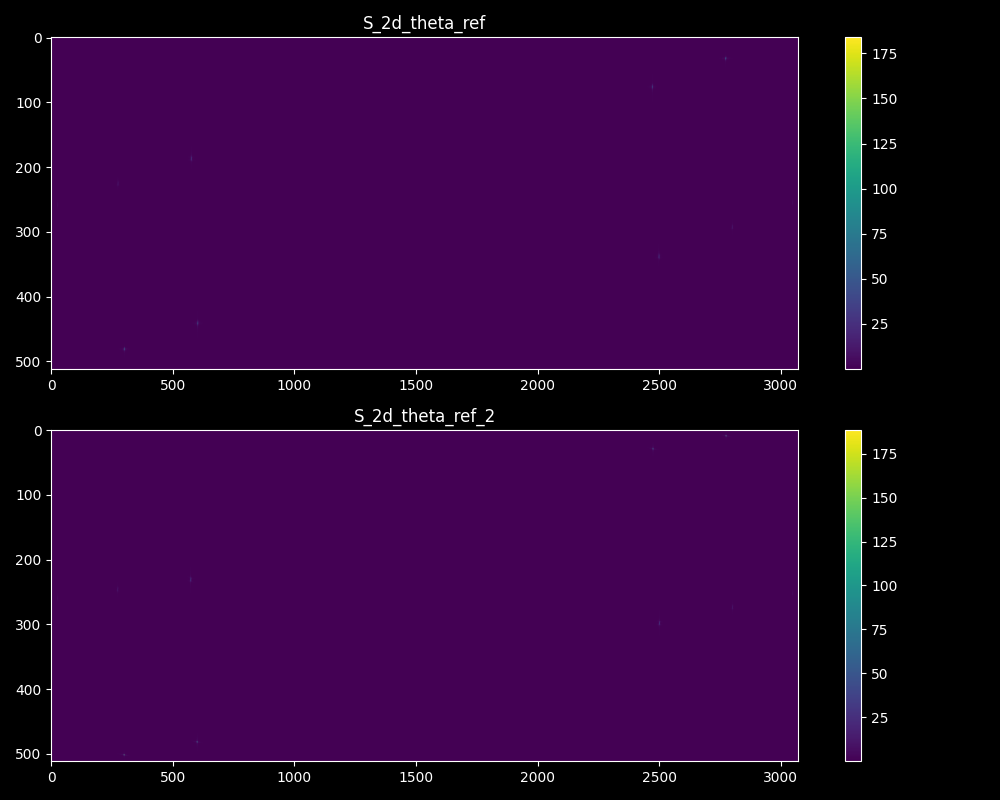

In [135]:

S_2d_theta_ref = np.fft.ifft2(S_2df_theta_ref)
S_2d_theta_ref_2 = np.fft.ifft2(S_2df_theta_ref_2)
print('max position and value after stolt:')
print(np.argmax(S_2d_theta_ref_2)//N_range_fft, np.remainder(np.argmax(S_2d_theta_ref_2),N_range_fft),np.max(np.abs(S_2d_theta_ref_2)))
print('max position and value before stolt:')
print(np.argmax(S_2d_theta_ref)//N_range_fft, np.remainder(np.argmax(S_2d_theta_ref),N_range_fft),np.max(np.abs(S_2d_theta_ref)))

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.imshow(np.abs(S_2d_theta_ref),aspect='auto')
# plt.xlim(1000,1500)
# plt.ylim(1000,1500)
plt.colorbar()
plt.title('S_2d_theta_ref')


plt.subplot(2,1,2)
plt.imshow(np.abs(S_2d_theta_ref_2),aspect='auto')
# plt.xlim(1000,1500)
# plt.ylim(1000,1500)
plt.colorbar()
plt.title('S_2d_theta_ref_2')


plt.tight_layout()
plt.show()



### 点目标置于景中心

In [136]:
H_rg_offset_a = 1
H_rg_offset_a *= np.exp(-1j*2*np.pi*(f_rg*Tr_total/2))
H_rg_cp_theta = 1
# H_rg_cp_theta *= np.exp(-1j*2*np.pi*(2*R_theta_ref/sc.c/D)*f_rg)

H_az_offset_a = 1
H_az_offset_a *= np.exp(1j*2*np.pi*(f_azi*Ta))
H_az_cp_theta = 1
# H_az_cp_theta *= np.exp(1j*2*np.pi*(sc.c*R_theta_ref*f_etac/2/D/f0/Vr**2)*f_azi)

S_2df_theta_ref_shift_center = S_2df_theta_ref*H_rg_offset_a*H_az_offset_a*H_rg_cp_theta*H_az_cp_theta
S_2df_theta_ref_2_shift_center = S_2df_theta_ref_2*H_rg_offset_a*H_az_offset_a*H_rg_cp_theta*H_az_cp_theta



S_2d_theta_ref_center = np.fft.ifft2(S_2df_theta_ref_shift_center)
S_2d_theta_ref_2_center = np.fft.ifft2(S_2df_theta_ref_2_shift_center)


print(np.argmax(S_2d_theta_ref_center)//N_range_fft, np.remainder(np.argmax(S_2d_theta_ref_center),N_range_fft),np.max(np.abs(S_2d_theta_ref_center)))
print(np.argmax(S_2d_theta_ref_2_center)//N_range_fft, np.remainder(np.argmax(S_2d_theta_ref_2_center),N_range_fft),np.max(np.abs(S_2d_theta_ref_2_center)))


256 1536 183.94423426913144
256 1536 188.5518271309289


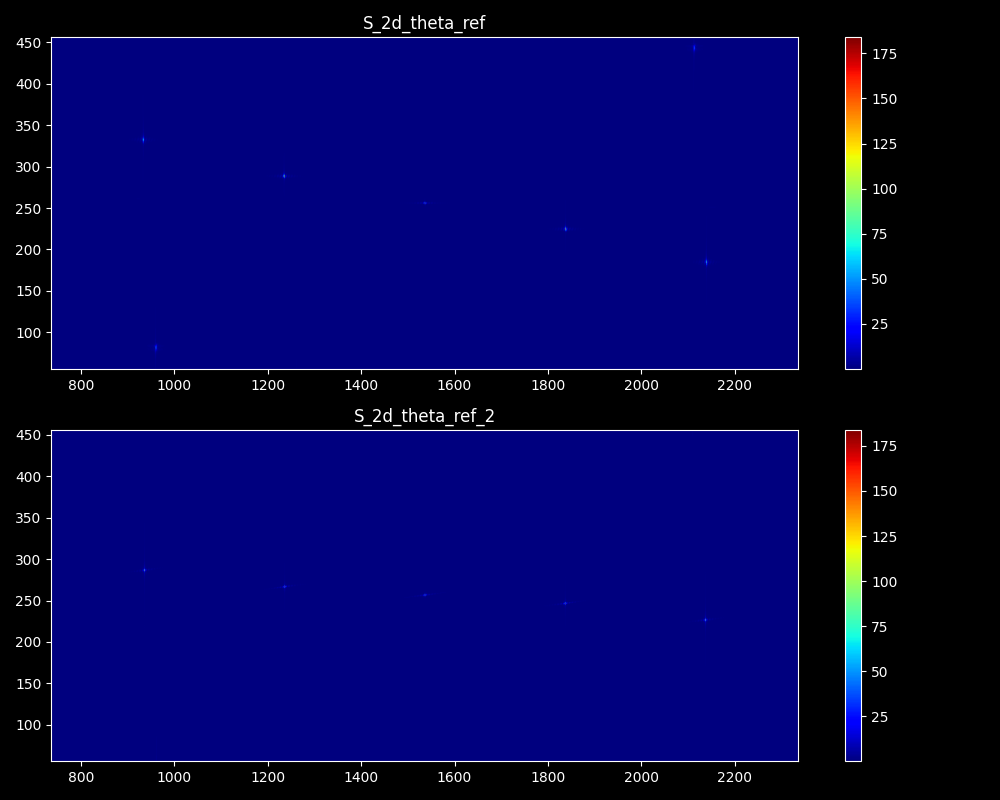

In [137]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.imshow(np.abs(S_2d_theta_ref_center),cmap = 'jet',
           vmax=np.max(np.abs(S_2d_theta_ref_center)),
           vmin=np.min(np.abs(S_2d_theta_ref_center)),
           aspect='auto'
           )
plt.xlim(int(N_rg/2)-800,int(N_rg/2)+800)
plt.ylim(int(N_az/2)-200,int(N_az/2)+200)
plt.colorbar()
plt.title('S_2d_theta_ref')


plt.subplot(2,1,2)
plt.imshow(np.abs(S_2d_theta_ref_2_center),cmap = 'jet',
            vmax=np.max(np.abs(S_2d_theta_ref_center)),
            vmin=np.min(np.abs(S_2d_theta_ref_center)),
            aspect='auto'
           )
plt.xlim(int(N_rg/2)-800,int(N_rg/2)+800)
plt.ylim(int(N_az/2)-200,int(N_az/2)+200)
plt.colorbar()
plt.title('S_2d_theta_ref_2')


plt.tight_layout()
plt.show()

### 找到所有点目标位置

In [138]:
def find_local_maxima_advanced(matrix, min_distance=2, threshold=None, exclude_border=True):
    """
    高级局部极大值检测
    
    参数:
    matrix: 二维矩阵
    min_distance: 极大值点之间的最小距离
    threshold: 极大值的最小阈值（可选）
    exclude_border: 是否排除边界点
    
    返回:
    maxima_coords: 极大值点坐标
    maxima_values: 极大值
    """
    from scipy.ndimage import maximum_filter
    import numpy as np
    
    # 应用最大值滤波
    size = 2 * min_distance + 1
    local_max = maximum_filter(matrix, size=size, mode='constant')
    
    # 创建极大值掩码
    maxima_mask = (matrix == local_max)
    
    # 排除边界
    if exclude_border:
        border = min_distance
        maxima_mask[:border, :] = False
        maxima_mask[-border:, :] = False
        maxima_mask[:, :border] = False
        maxima_mask[:, -border:] = False
    
    # 应用阈值
    if threshold is not None:
        maxima_mask = maxima_mask & (matrix >= threshold)
    
    # 非极大值抑制（确保每个局部区域只有一个极大值）
    maxima_coords = np.argwhere(maxima_mask)
    maxima_values = matrix[tuple(maxima_coords.T)]
    
    # 按值排序（从大到小）
    if len(maxima_values) > 0:
        sorted_indices = np.argsort(-maxima_values)
        maxima_coords = maxima_coords[sorted_indices]
        maxima_values = maxima_values[sorted_indices]
    
    return maxima_coords, maxima_values

max1,max2 = np.max(np.abs(S_2d_theta_ref_center)),np.max(np.abs(S_2d_theta_ref_2_center))
coord_1,points_1 = find_local_maxima_advanced(np.abs(S_2d_theta_ref_center),min_distance = 10,threshold = 0.5*max1)
coord_2,points_2 = find_local_maxima_advanced(np.abs(S_2d_theta_ref_2_center),min_distance = 10,threshold = 0.5*max2)
print(coord_1)
print(coord_2)

[[ 256 1536]
 [ 225 1837]
 [ 288 1235]]
[[ 256 1536]
 [ 246 1836]
 [ 266 1236]
 [ 226 2136]
 [ 286  936]]


### 中心点目标放大

center position: 256 1536
center position 2: 256 1536


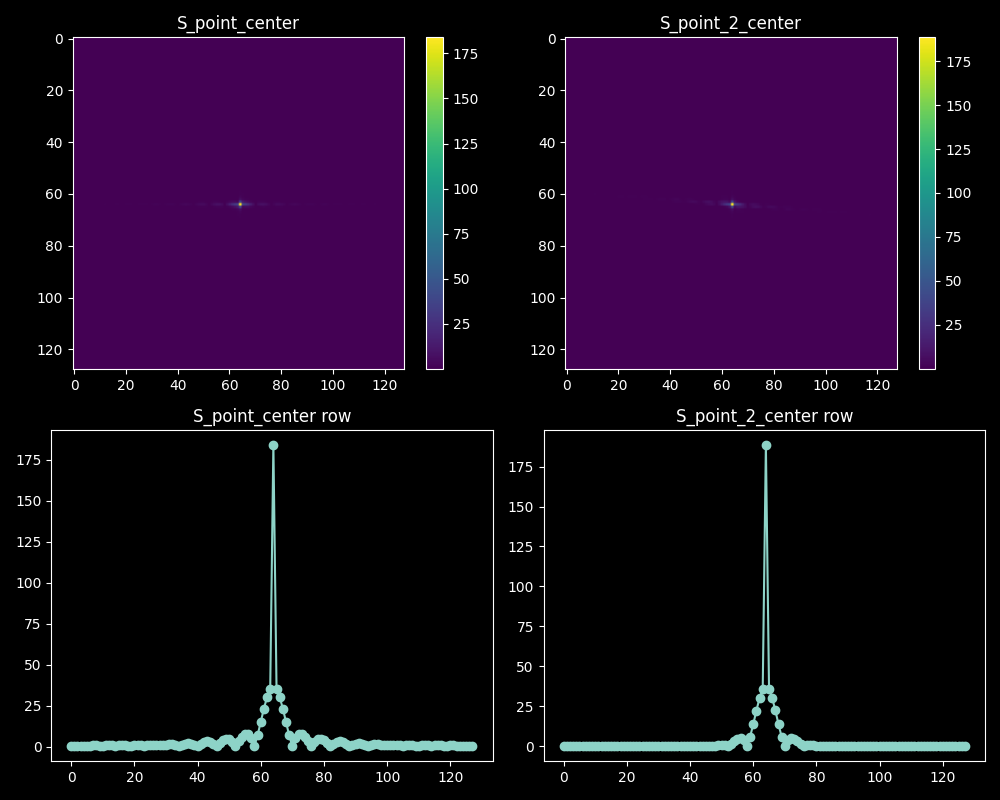

In [139]:
y1,x1 = np.argmax(S_2d_theta_ref_center)//N_range_fft,np.remainder(np.argmax(S_2d_theta_ref_center),N_range_fft)
y1,x1 = int(y1),int(x1)
y2,x2 = np.argmax(S_2d_theta_ref_2_center)//N_range_fft, np.remainder(np.argmax(S_2d_theta_ref_2_center),N_range_fft)
y2,x2 = int(y2),int(x2)
print('center position:',y1,x1)
print('center position 2:',y2,x2)
# print(x2 - 1e3/(sc.c/2/Fr))
y1,x1 = int(N_azimuth_fft/2), int(N_range_fft/2)
y2,x2 = int(N_azimuth_fft/2), int(N_range_fft/2)
N = 128
NN = int(N/2)
S_point_center = S_2d_theta_ref_center[y1-NN:y1+NN,x1-NN:x1+NN]
S_point_2_center = S_2d_theta_ref_2_center[y2-NN:y2+NN,x2-NN:x2+NN]
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(np.abs(S_point_center))
plt.colorbar()
plt.title('S_point_center')
plt.subplot(2,2,2)
plt.imshow(np.abs(S_point_2_center))
plt.colorbar()
plt.title('S_point_2_center')
plt.subplot(2,2,3)
plt.plot(np.abs(S_point_center[int(NN),:]),'-o')
plt.title('S_point_center row')
plt.subplot(2,2,4)
plt.plot(np.abs(S_point_2_center[int(NN),:]),'-o')
plt.title('S_point_2_center row')
plt.tight_layout()
plt.show()

## 升采样

### 待采样点目标

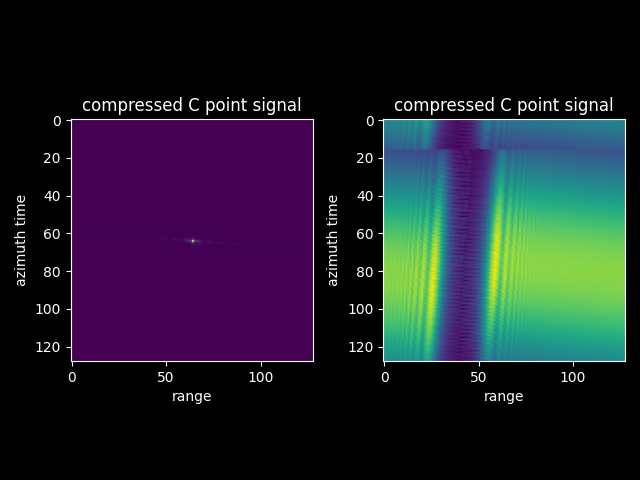

In [140]:
point_target = S_point_2_center
plt.figure()
plt.subplot(1,2,1)
plt.imshow((np.abs(point_target)))
plt.title('compressed C point signal')
plt.xlabel('range')
plt.ylabel('azimuth time')

plt.subplot(1,2,2)
plt.imshow(np.abs((sf.fft2((point_target)))))
plt.title('compressed C point signal')
plt.xlabel('range')
plt.ylabel('azimuth time')

plt.tight_layout()
plt.show()

### 对目标进行升采样

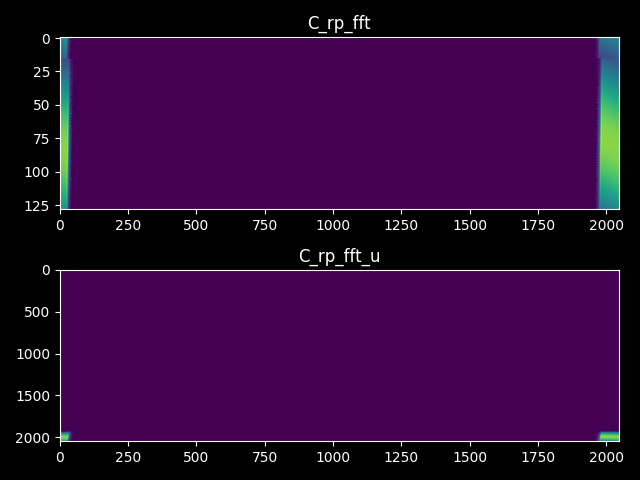

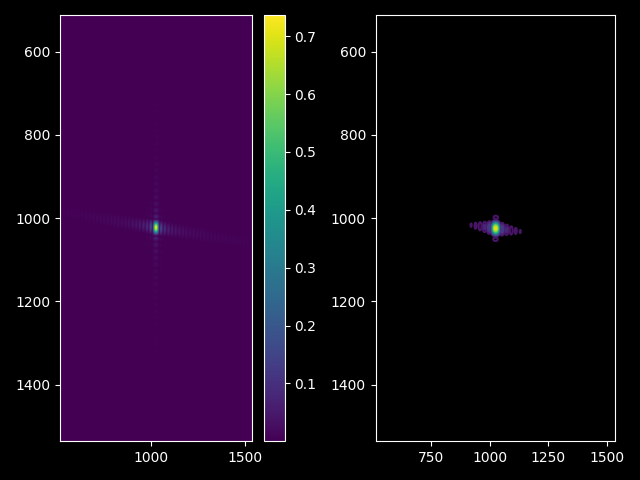

In [141]:
K = 16
C_2ft = sf.fft2((point_target))
C_rp_fft = np.zeros([N,K*N],dtype=np.complex128)
for i in range(N):
    x_min = np.argmin(np.abs(C_2ft[i,:]))
    # print('x_min:',x_min)
    C_rp_fft[i,0:x_min] = C_2ft[i,0:x_min]
    C_rp_fft[i,K*N-(N-x_min):K*N] = C_2ft[i,x_min:2*N]

C_rp_fft_u = np.zeros([K*N,K*N],dtype=np.complex128)
for j in range(K*N):
    y_min = np.argmin(np.abs(C_rp_fft[:,j]))
    C_rp_fft_u[0:y_min,j] = C_rp_fft[0:y_min,j]
    C_rp_fft_u[K*N-(N-y_min):K*N,j] = C_rp_fft[y_min:N,j]

plt.figure()
plt.subplot(2,1,1)
plt.imshow(np.abs(C_rp_fft),aspect='auto')
plt.title('C_rp_fft')
plt.subplot(2,1,2)
plt.imshow(np.abs(C_rp_fft_u),aspect='auto')
plt.title('C_rp_fft_u')
plt.tight_layout()
plt.show()

c_ups = sf.ifft2(C_rp_fft_u )
# c_ups = ss.resample(ss.resample(C_point,K*N,axis=-1),K*N,axis=0)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(c_ups),aspect='auto')
plt.xlim(int(K*N/4),3*int(K*N/4))
plt.ylim(3*int(K*N/4),int(K*N/4))
plt.colorbar()

plt.subplot(1,2,2)
plt.contour((np.linspace(0,K*N,K*N)),(np.linspace(0,K*N,K*N)),\
             np.abs(c_ups),levels = 20)
plt.xlim(int(K*N/4),3*int(K*N/4))
plt.ylim(3*int(K*N/4),int(K*N/4))
plt.tight_layout()
plt.show()

### 升采样分析

#### 定义交互式绘图函数

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%matplotlib widget

class InteractiveProfileExtractor:
    def __init__(self, image_data):
        self.image_data = np.abs(image_data)
        self.image_angle = np.angle(image_data)
        self.fig, self.ax = plt.subplots(1, 1, figsize=(8, 6))
        
        # 显示图像
        self.im = self.ax.imshow(self.image_data, cmap='viridis', origin='lower')
        self.ax.set_title('click and move the arrow')
        
        # 初始化箭头
        self.arrow = None
        self.start_point = None
        self.end_point = None
        
        # 创建输出区域
        self.output = widgets.Output()
        
        # 创建控制按钮
        self.clear_button = widgets.Button(description="clean arrow")
        self.clear_button.on_click(self.clear_arrow)
        
        # 显示控件
        display(widgets.VBox([self.clear_button, self.output]))
        
        # 连接事件
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)
    
    def on_press(self, event):
        if event.inaxes != self.ax:
            return
        self.start_point = (event.xdata, event.ydata)
    
    def on_motion(self, event):
        if self.start_point is None or event.inaxes != self.ax:
            return
        
        # 清除之前的箭头
        if self.arrow:
            self.arrow.remove()
        
        # 绘制临时箭头
        dx = event.xdata - self.start_point[0]
        dy = event.ydata - self.start_point[1]
        self.arrow = plt.Arrow(self.start_point[0], self.start_point[1], 
                              dx, dy, width=0.5, color='red', alpha=0.7)
        self.ax.add_patch(self.arrow)
        self.fig.canvas.draw()
    
    def on_release(self, event):
        if self.start_point is None or event.inaxes != self.ax:
            return
        
        self.end_point = (event.xdata, event.ydata)
        
        # 绘制最终箭头
        if self.arrow:
            self.arrow.remove()
        
        dx = self.end_point[0] - self.start_point[0]
        dy = self.end_point[1] - self.start_point[1]
        self.arrow = plt.Arrow(self.start_point[0], self.start_point[1], 
                              dx, dy, width=0.5, color='red')
        self.ax.add_patch(self.arrow)
        
        # 计算并显示剖面
        self.plot_profile()
        
        self.fig.canvas.draw()
        self.start_point = None
    
    def plot_profile(self):
        """计算并显示沿箭头方向的剖面"""
        with self.output:
            self.output.clear_output(wait=True)
            
            if self.start_point is None or self.end_point is None:
                return
            
            # 计算箭头方向上的点
            x0, y0 = self.start_point
            x1, y1 = self.end_point
            
            # 计算箭头长度
            length = np.sqrt((x1-x0)**2 + (y1-y0)**2)
            
            # 沿箭头方向采样
            num_points = int(length * 2)
            x_points = np.linspace(x0, x1, num_points)
            y_points = np.linspace(y0, y1, num_points)
            
            # 提取沿箭头的值
            profile_values = []
            profile_angles = []
            distances = []
            
            for i, (x, y) in enumerate(zip(x_points, y_points)):
                if 0 <= x < self.image_data.shape[1]-1 and 0 <= y < self.image_data.shape[0]-1:
                    # 双线性插值
                    x_floor, y_floor = int(x), int(y)
                    x_frac, y_frac = x - x_floor, y - y_floor
                    
                    value = (1-x_frac)*(1-y_frac)*self.image_data[y_floor, x_floor] + \
                            x_frac*(1-y_frac)*self.image_data[y_floor, x_floor+1] + \
                            (1-x_frac)*y_frac*self.image_data[y_floor+1, x_floor] + \
                            x_frac*y_frac*self.image_data[y_floor+1, x_floor+1]
                    
                    angle = (1-x_frac)*(1-y_frac)*self.image_angle[y_floor, x_floor] + \
                            x_frac*(1-y_frac)*self.image_angle[y_floor, x_floor+1] + \
                            (1-x_frac)*y_frac*self.image_angle[y_floor+1, x_floor] + \
                            x_frac*y_frac*self.image_angle[y_floor+1, x_floor+1]

                    profile_values.append(value)
                    profile_angles.append(angle)
                    distances.append(i/length)  # 归一化距离
            
            # 创建剖面图
            fig_profile, ax_profile = plt.subplots(1, 2, figsize=(8, 4))
            if profile_values:
                ax_profile[0].plot(distances, 20*np.log10(profile_values), 'b-', linewidth=2)
                ax_profile[0].set_title('alone arrow')
                ax_profile[0].set_xlabel('normilized range')
                ax_profile[0].set_ylabel('amplitude (dB)')
                ax_profile[0].grid(True, alpha=0.3)

                ax_profile[1].plot(distances, np.angle(profile_angles), 'b-', linewidth=2)
                ax_profile[1].set_title('alone arrow')
                ax_profile[1].set_xlabel('normilized range')
                ax_profile[1].set_ylabel('phase (rad)')
                ax_profile[1].grid(True, alpha=0.3)
                plt.show()
    
    def clear_arrow(self, b):
        """清除箭头"""
        if self.arrow:
            self.arrow.remove()
            self.arrow = None
            self.fig.canvas.draw()
        self.output.clear_output()

# 使用示例
# data = np.random.rand(100, 100)  # 您的数据
# interactive_profile = InteractiveProfileExtractor(data)

#### 升采样点目标分析

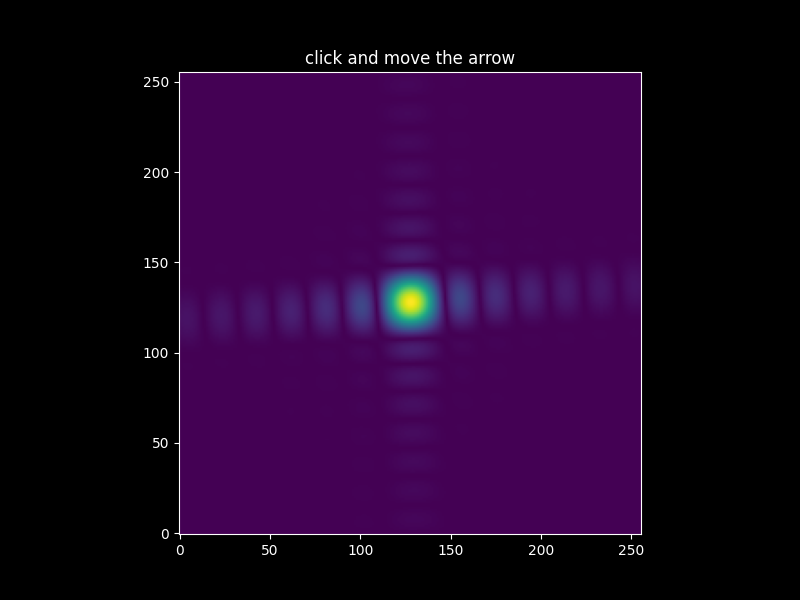

In [ ]:
%matplotlib widget

ups_center_y,ups_center_x = np.abs(c_ups).argmax()//c_ups.shape[1],\
                            np.remainder(np.abs(c_ups).argmax(),c_ups.shape[1])
c_ups = c_ups/np.max(np.abs(c_ups))
NR = 128
focus_image = c_ups[ups_center_y-NR:ups_center_y+NR,ups_center_x-NR:ups_center_x+NR]
interactive_profile = InteractiveProfileExtractor((focus_image))
